# Feature Extraction – medhalf + Logos  
## Vision Transformer (ViT) – Features, Metrics & Visualizations

- Medical dataset: `C:\Users\bacht\Desktop\medhalf`
  - Classes: `ModerateDemented_processed`, `NonDemented_processed`, `notumor_processed`, `pituitary_processed`
  - Images directement dans chaque dossier (déjà prétraitées).
- Logo dataset: `C:\Users\bacht\Desktop\ITFFC\logos`
  - Sous-dossiers: `Train`, `Test`, eux-mêmes avec plusieurs dossiers de logos.
  - Tous les logos sont traités comme **une seule classe** `"logo"`.

Objectifs :
1. Charger les deux datasets (med + logos).
2. Extraire des features avec **ViT (vit_base_patch16_224)**.
3. Sauvegarder les features dans `medhalf/features_vit`.
4. Évaluer les features (compacité, distinctivité, silhouette).
5. Visualiser via PCA, t-SNE et UMAP.


In [1]:
import os
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Chemins ---
MED_ROOT   = Path(r"C:\Users\bacht\Desktop\medhalf")
LOGO_ROOT  = Path(r"C:\Users\bacht\Desktop\ITFFC\logos")   # Train / Test

# Dossier de sortie pour ViT
FEATURES_DIR = MED_ROOT / "features_vit"
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

print("MED_ROOT     :", MED_ROOT)
print("LOGO_ROOT    :", LOGO_ROOT)
print("FEATURES_DIR :", FEATURES_DIR)

# --- Paramètres globaux ---
IMG_SIZE    = 224
BATCH_SIZE  = 32
NUM_WORKERS = 0   # Windows -> 0 pour éviter les soucis
SEED        = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

# petit warning friendly
if not MED_ROOT.exists():
    raise FileNotFoundError(f"MED_ROOT introuvable: {MED_ROOT}")
if not LOGO_ROOT.exists():
    raise FileNotFoundError(f"LOGO_ROOT introuvable: {LOGO_ROOT}")


Torch: 2.6.0+cu124
CUDA available: True
MED_ROOT     : C:\Users\bacht\Desktop\medhalf
LOGO_ROOT    : C:\Users\bacht\Desktop\ITFFC\logos
FEATURES_DIR : C:\Users\bacht\Desktop\medhalf\features_vit


--- Aperçu MED ---
  split                       class  \
0   All  ModerateDemented_processed   
1   All  ModerateDemented_processed   
2   All  ModerateDemented_processed   
3   All  ModerateDemented_processed   
4   All  ModerateDemented_processed   

                                                path  
0  C:\Users\bacht\Desktop\medhalf\ModerateDemente...  
1  C:\Users\bacht\Desktop\medhalf\ModerateDemente...  
2  C:\Users\bacht\Desktop\medhalf\ModerateDemente...  
3  C:\Users\bacht\Desktop\medhalf\ModerateDemente...  
4  C:\Users\bacht\Desktop\medhalf\ModerateDemente...   

Total images MED: 12800

--- Aperçu LOGOS ---
       split class                                               path
0  LogoTrain  logo  C:\Users\bacht\Desktop\ITFFC\logos\Train\Alber...
1  LogoTrain  logo  C:\Users\bacht\Desktop\ITFFC\logos\Train\Alber...
2  LogoTrain  logo  C:\Users\bacht\Desktop\ITFFC\logos\Train\Alber...
3  LogoTrain  logo  C:\Users\bacht\Desktop\ITFFC\logos\Train\Alber...
4  LogoTrain  logo

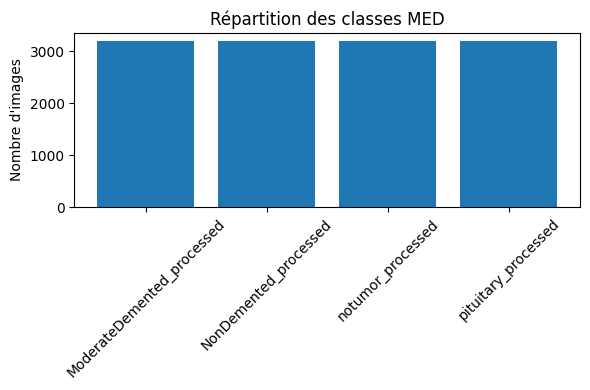

In [2]:
# --- Scan MEDHALF (4 classes) ---

def scan_medhalf(root: Path) -> pd.DataFrame:
    """
    Retourne un DataFrame avec colonnes: split, class, path
    (ici split='All' pour tout le dataset).
    """
    rows = []
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

    for class_dir in sorted(root.iterdir()):
        if not class_dir.is_dir():
            continue
        cls_name = class_dir.name
        for p in class_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                rows.append({
                    "split": "All",
                    "class": cls_name,
                    "path": str(p)
                })
    return pd.DataFrame(rows)


# --- Scan LOGOS (Train + Test, une seule classe 'logo') ---

def scan_logos(root: Path) -> pd.DataFrame:
    rows = []
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

    for split in ["Train", "Test"]:
        split_dir = root / split
        if not split_dir.exists():
            print(f"[warning] Split logo non trouvé: {split_dir}")
            continue

        for p in split_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                rows.append({
                    "split": f"Logo{split}",
                    "class": "logo",
                    "path": str(p)
                })
    return pd.DataFrame(rows)


med_df  = scan_medhalf(MED_ROOT)
logo_df = scan_logos(LOGO_ROOT)

print("--- Aperçu MED ---")
print(med_df.head(), "\n")
print("Total images MED:", len(med_df))

print("\n--- Aperçu LOGOS ---")
print(logo_df.head(), "\n")
print("Total images LOGOS:", len(logo_df))


# --- Répartition des classes MED ---
counts_med = med_df.groupby("class").size().reset_index(name="count")
print("\nRépartition MED:")
print(counts_med)

plt.figure(figsize=(6,4))
plt.bar(counts_med["class"], counts_med["count"])
plt.xticks(rotation=45)
plt.ylabel("Nombre d'images")
plt.title("Répartition des classes MED")
plt.tight_layout()
plt.show()


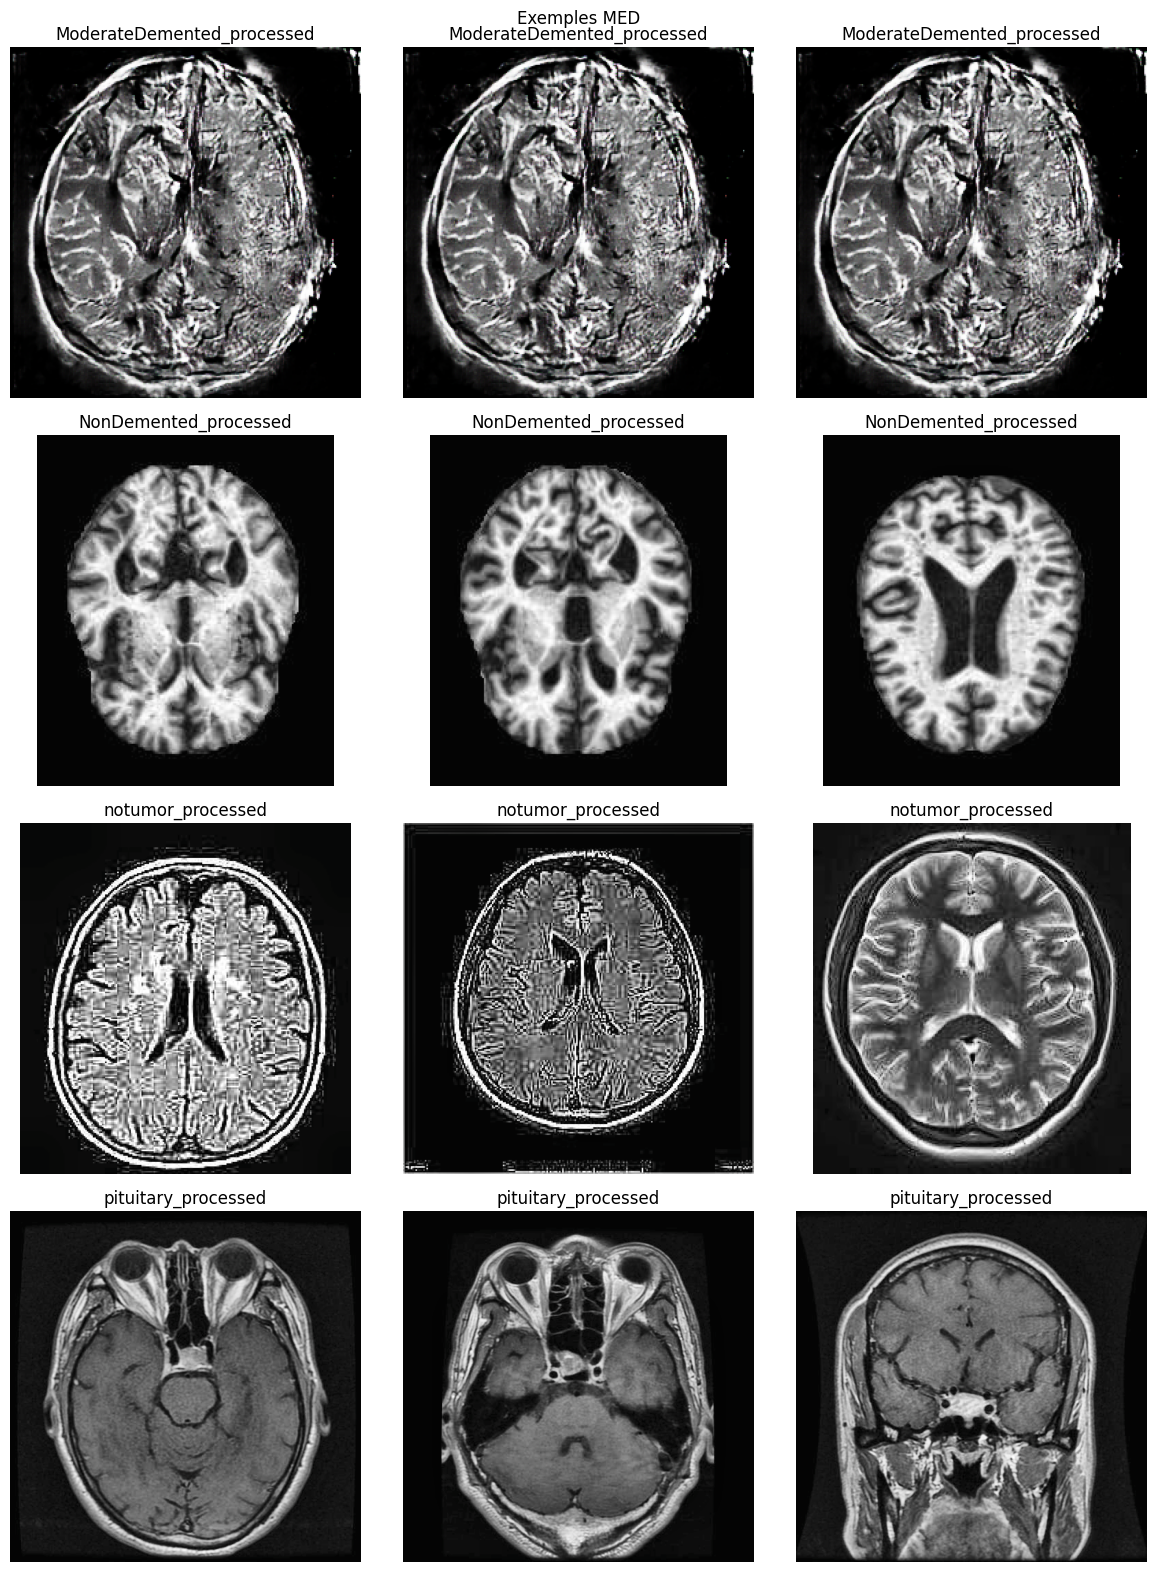

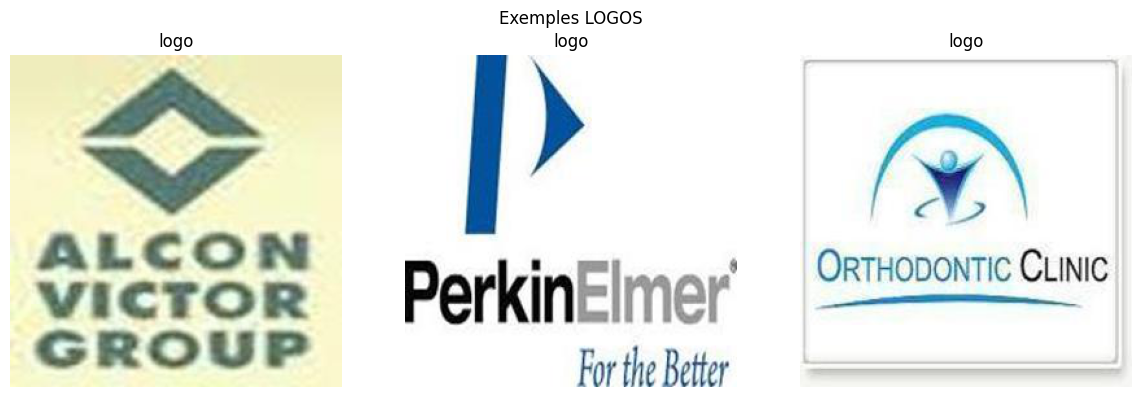

In [3]:
def show_samples(df: pd.DataFrame, title: str, n_per_class: int = 4):
    if df.empty:
        print(f"[info] Pas d'images pour {title}")
        return
    classes = df["class"].unique()
    plt.figure(figsize=(4*n_per_class, 4*len(classes)))
    idx = 1
    for cls in classes:
        sub = df[df["class"] == cls]
        if len(sub) == 0:
            continue
        sub = sub.sample(min(len(sub), n_per_class), random_state=SEED)
        for _, row in sub.iterrows():
            img = Image.open(row["path"]).convert("RGB")
            plt.subplot(len(classes), n_per_class, idx)
            plt.imshow(img)
            plt.axis("off")
            plt.title(cls)
            idx += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


show_samples(med_df,  "Exemples MED",   n_per_class=3)
show_samples(logo_df, "Exemples LOGOS", n_per_class=3)


In [4]:
from torchvision import transforms

class MedDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_size: int = 224):
        self.df = df.reset_index(drop=True)
        self.classes = sorted(df["class"].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        x = self.tf(img)
        y = self.class_to_idx[row["class"]]
        return x, y


class LogoDatasetFlat(Dataset):
    """
    Tous les logos en une seule classe 'logo'.
    """
    def __init__(self, df: pd.DataFrame, img_size: int = 224):
        self.df = df.reset_index(drop=True)
        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        x = self.tf(img)
        y = 0  # single class
        return x, y


med_ds   = MedDataset(med_df, img_size=IMG_SIZE)
logo_ds  = LogoDatasetFlat(logo_df, img_size=IMG_SIZE)

med_dl   = DataLoader(med_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)
logo_dl  = DataLoader(logo_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

print("MED dataset size  :", len(med_ds),  " | classes:", med_ds.classes)
print("LOGO dataset size :", len(logo_ds), " | classes: ['logo']")


MED dataset size  : 12800  | classes: ['ModerateDemented_processed', 'NonDemented_processed', 'notumor_processed', 'pituitary_processed']
LOGO dataset size : 4480  | classes: ['logo']


In [5]:
try:
    import timm
except ImportError as e:
    print("⚠️ timm n'est pas installé. Installe-le avec :")
    print("   pip install timm")
    raise e

class ViTFeatureExtractor(nn.Module):
    """
    ViT-B/16 (224x224) pré-entraîné, retourne un vecteur de dimension 768.
    On utilise le token CLS comme représentation globale.
    """
    def __init__(self):
        super().__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.reset_classifier(0)  # enlever la tête de classification
        self.vit.eval()

    def forward(self, x):
        # timm: forward_features retourne souvent [B, tokens, C] ou [B, C]
        feats = self.vit.forward_features(x)
        if feats.dim() == 3:
            # format [B, tokens, C] -> on prend le token CLS (position 0)
            feats = feats[:, 0, :]
        return feats


def build_vit_extractor():
    m = ViTFeatureExtractor()
    m.eval().to(device)
    feat_dim = 768
    return m, feat_dim


@torch.no_grad()
def extract_features(backbone: nn.Module, loader: DataLoader, feat_dim: int) -> np.ndarray:
    feats = np.zeros((len(loader.dataset), feat_dim), dtype=np.float32)
    ptr = 0
    for xb, yb in loader:
        xb = xb.to(device)
        out = backbone(xb)
        out = out.detach().cpu().numpy()
        n = out.shape[0]
        feats[ptr:ptr+n] = out
        ptr += n
    return feats


def save_features(prefix: str, df: pd.DataFrame, feats: np.ndarray, model_tag: str):
    npy_path = FEATURES_DIR / f"{prefix}_{model_tag}_features.npy"
    np.save(npy_path, feats)

    meta = pd.DataFrame({
        "path": df["path"].values,
        "class": df["class"].values,
        "split": df["split"].values,
    })
    csv_path = FEATURES_DIR / f"{prefix}_{model_tag}_meta.csv"
    meta.to_csv(csv_path, index=False)

    print(f"Saved: {npy_path.name}, {csv_path.name}")


In [6]:
vit_model, vit_dim = build_vit_extractor()
print("ViT feature dimension:", vit_dim)

# --- MED ---
print("[MED] Extraction ViT features...")
med_vit_feats = extract_features(vit_model, med_dl, vit_dim)
save_features("med", med_df, med_vit_feats, "vit")

# --- LOGOS ---
print("[LOGO] Extraction ViT features...")
logo_vit_feats = extract_features(vit_model, logo_dl, vit_dim)
save_features("logo", logo_df, logo_vit_feats, "vit")

print("\n✅ Extraction terminée. Fichiers présents dans:", FEATURES_DIR)
for p in sorted(FEATURES_DIR.glob("*.npy")):
    print(" -", p.name)
for p in sorted(FEATURES_DIR.glob("*.csv")):
    print(" -", p.name)


ViT feature dimension: 768
[MED] Extraction ViT features...
Saved: med_vit_features.npy, med_vit_meta.csv
[LOGO] Extraction ViT features...
Saved: logo_vit_features.npy, logo_vit_meta.csv

✅ Extraction terminée. Fichiers présents dans: C:\Users\bacht\Desktop\medhalf\features_vit
 - logo_vit_features.npy
 - med_vit_features.npy
 - logo_vit_meta.csv
 - med_vit_meta.csv


In [7]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

def compute_compactness(features: np.ndarray, labels: np.ndarray) -> float:
    """
    Compacité intra-classe (plus petit = mieux).
    """
    unique_labels = np.unique(labels)
    per_class_vals = []

    for c in unique_labels:
        idx = (labels == c)
        feats_c = features[idx]
        if len(feats_c) < 2:
            continue
        centroid = feats_c.mean(axis=0, keepdims=True)
        dists = np.linalg.norm(feats_c - centroid, axis=1)
        per_class_vals.append(dists.mean())

    if len(per_class_vals) == 0:
        return np.nan
    return float(np.mean(per_class_vals))


def compute_distinctiveness(features: np.ndarray, labels: np.ndarray) -> float:
    """
    Distinctivité inter-classe (plus grand = mieux).
    """
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return np.nan

    centroids = []
    for c in unique_labels:
        idx = (labels == c)
        feats_c = features[idx]
        centroids.append(feats_c.mean(axis=0))
    centroids = np.stack(centroids, axis=0)

    dists = cdist(centroids, centroids, metric="euclidean")
    i_upper = np.triu_indices_from(dists, k=1)
    return float(dists[i_upper].mean())


def compute_silhouette(features: np.ndarray, labels: np.ndarray) -> float:
    """
    Silhouette globale [-1,1] (plus grand = meilleures séparations).
    """
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        print("Silhouette non définie: une seule classe.")
        return np.nan
    if len(features) < 3:
        print("Silhouette non définie: trop peu d'échantillons.")
        return np.nan
    return float(silhouette_score(features, labels))


In [8]:
# préparation des labels pour MED
med_labels_name = med_df["class"].values
med_classes     = sorted(np.unique(med_labels_name))
med_class_to_idx = {c: i for i, c in enumerate(med_classes)}
med_labels_idx   = np.array([med_class_to_idx[c] for c in med_labels_name], dtype=np.int64)

print("MED classes:", med_classes)

med_compact = compute_compactness(med_vit_feats, med_labels_idx)
med_distinct = compute_distinctiveness(med_vit_feats, med_labels_idx)
med_sil = compute_silhouette(med_vit_feats, med_labels_idx)

print("=== Metrics: MED (ViT) ===")
print(f"Compacité (↓):      {med_compact:.4f}")
print(f"Distinctivité (↑):  {med_distinct:.4f}")
print(f"Silhouette (↑):     {med_sil:.4f}")

# Logos: une seule classe 'logo'
logo_labels_name = logo_df["class"].values  # tout = "logo"
logo_labels_idx  = np.zeros(len(logo_labels_name), dtype=np.int64)

logo_compact = compute_compactness(logo_vit_feats, logo_labels_idx)
logo_distinct = compute_distinctiveness(logo_vit_feats, logo_labels_idx)
logo_sil = compute_silhouette(logo_vit_feats, logo_labels_idx)

print("\n=== Metrics: LOGO (ViT) ===")
print(f"Compacité (↓):      {logo_compact:.4f}")
print(f"Distinctivité (↑):  {logo_distinct}")  # nan attendu
print(f"Silhouette (↑):     {logo_sil}")       # nan attendu
print("(Distinctivité / silhouette non définies avec une seule classe.)")


MED classes: ['ModerateDemented_processed', 'NonDemented_processed', 'notumor_processed', 'pituitary_processed']
=== Metrics: MED (ViT) ===
Compacité (↓):      20.3401
Distinctivité (↑):  43.6850
Silhouette (↑):     0.4245
Silhouette non définie: une seule classe.

=== Metrics: LOGO (ViT) ===
Compacité (↓):      36.4848
Distinctivité (↑):  nan
Silhouette (↑):     nan
(Distinctivité / silhouette non définies avec une seule classe.)


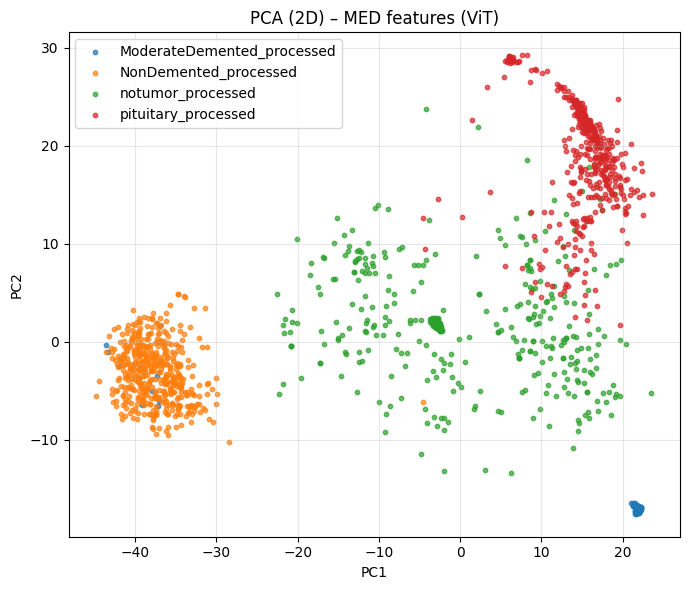

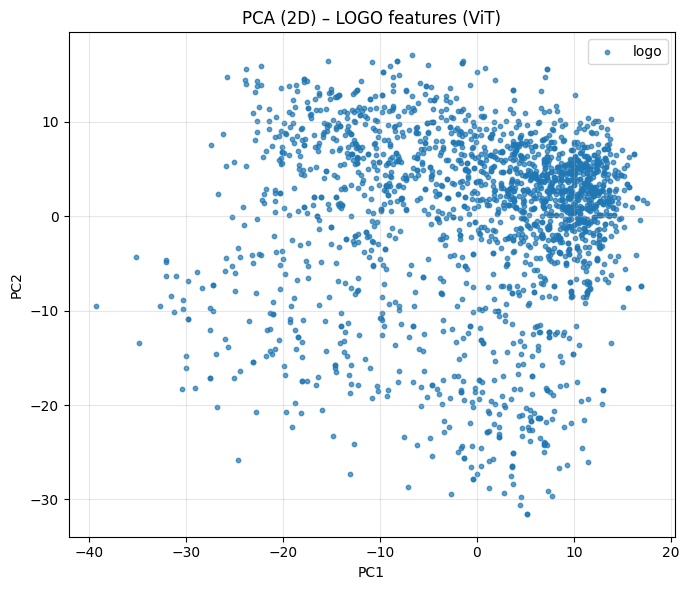

In [9]:
from sklearn.decomposition import PCA

def pca_scatter(features: np.ndarray, labels_name: np.ndarray,
                title: str, max_points: int = 2000):
    n = len(features)
    if n > max_points:
        idx = np.random.choice(n, size=max_points, replace=False)
        feats_sub = features[idx]
        labels_sub = labels_name[idx]
    else:
        feats_sub = features
        labels_sub = labels_name

    pca = PCA(n_components=2, random_state=SEED)
    feats_2d = pca.fit_transform(feats_sub)

    plt.figure(figsize=(7,6))
    classes = sorted(np.unique(labels_sub))
    for cls in classes:
        mask = (labels_sub == cls)
        plt.scatter(feats_2d[mask, 0], feats_2d[mask, 1], s=10, alpha=0.7, label=str(cls))
    plt.legend()
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


pca_scatter(med_vit_feats,  med_labels_name,  "PCA (2D) – MED features (ViT)")
pca_scatter(logo_vit_feats, logo_labels_name, "PCA (2D) – LOGO features (ViT)")


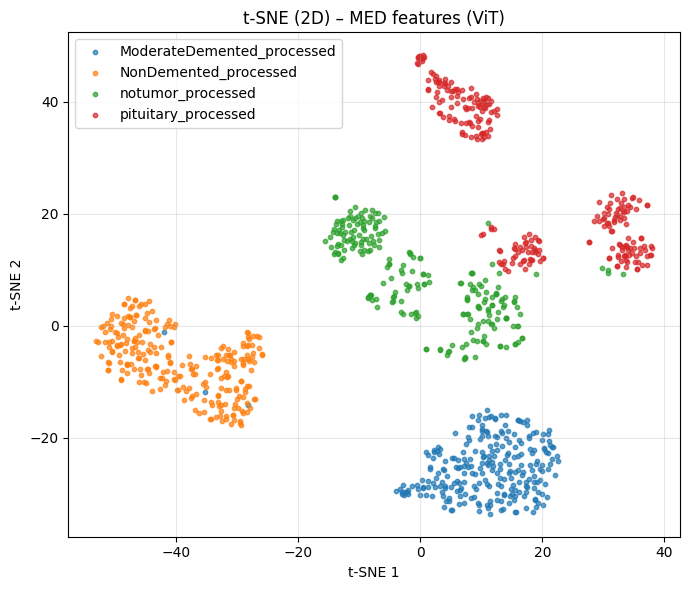

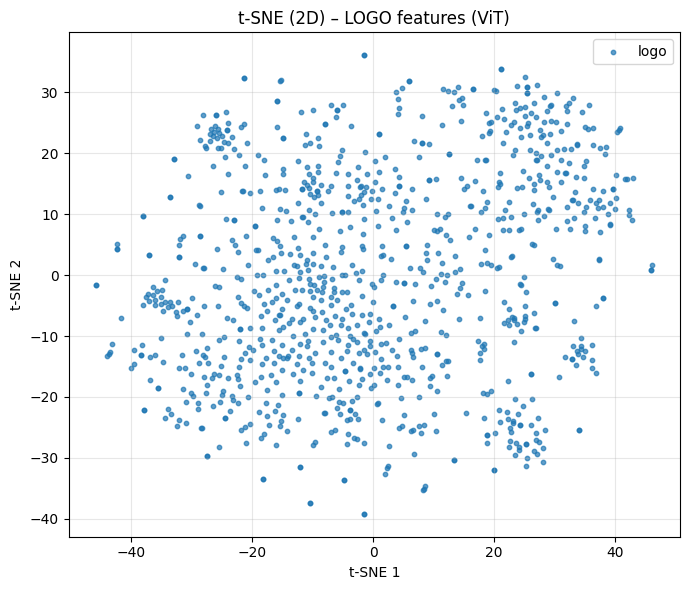

In [10]:
from sklearn.manifold import TSNE

def tsne_scatter(features: np.ndarray, labels_name: np.ndarray,
                 title: str, max_points: int = 1000, perplexity: float = 30.0):
    n = len(features)
    if n > max_points:
        idx = np.random.choice(n, size=max_points, replace=False)
        feats_sub = features[idx]
        labels_sub = labels_name[idx]
    else:
        feats_sub = features
        labels_sub = labels_name

    tsne = TSNE(n_components=2, perplexity=perplexity, init="pca",
                learning_rate="auto", random_state=SEED)
    feats_2d = tsne.fit_transform(feats_sub)

    plt.figure(figsize=(7,6))
    classes = sorted(np.unique(labels_sub))
    for cls in classes:
        mask = (labels_sub == cls)
        plt.scatter(feats_2d[mask, 0], feats_2d[mask, 1], s=10, alpha=0.7, label=str(cls))
    plt.legend()
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


tsne_scatter(med_vit_feats,  med_labels_name,  "t-SNE (2D) – MED features (ViT)")
tsne_scatter(logo_vit_feats, logo_labels_name, "t-SNE (2D) – LOGO features (ViT)")


C:\Users\bacht\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


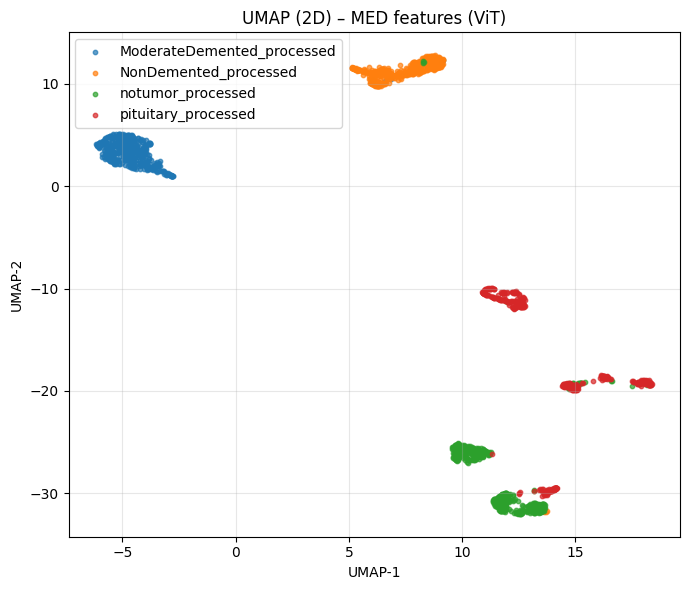

C:\Users\bacht\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


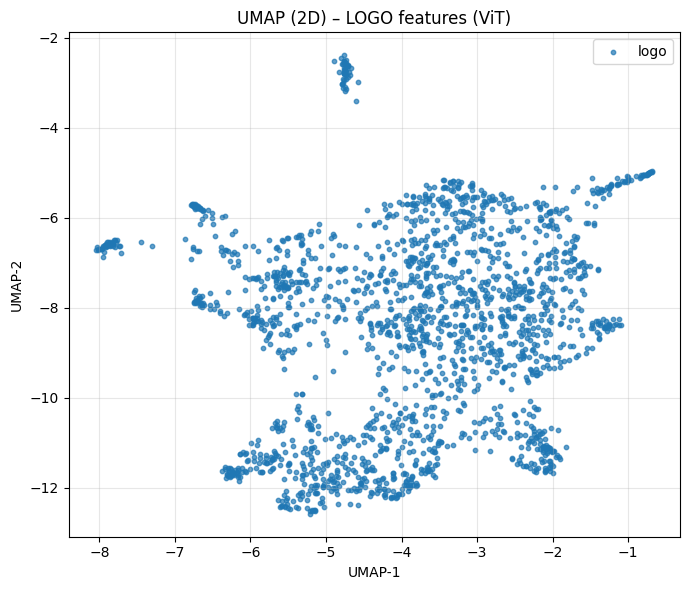

In [11]:
try:
    import umap
    from umap import UMAP
except Exception as e:
    print("⚠️ UMAP non disponible. Vérifie que 'umap-learn' est bien installé.")
    raise e

def umap_scatter(features: np.ndarray,
                 labels_name: np.ndarray,
                 title: str,
                 max_points: int = 2000,
                 n_neighbors: int = 15,
                 min_dist: float = 0.1):
    n = len(features)
    if n > max_points:
        idx = np.random.choice(n, size=max_points, replace=False)
        feats_sub = features[idx]
        labels_sub = labels_name[idx]
    else:
        feats_sub = features
        labels_sub = labels_name

    reducer = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="euclidean",
        random_state=SEED,
    )
    embeds_2d = reducer.fit_transform(feats_sub)

    plt.figure(figsize=(7,6))
    classes = sorted(np.unique(labels_sub))
    for cls in classes:
        mask = (labels_sub == cls)
        plt.scatter(embeds_2d[mask, 0], embeds_2d[mask, 1],
                    s=10, alpha=0.7, label=str(cls))
    plt.legend()
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


umap_scatter(med_vit_feats,  med_labels_name,  "UMAP (2D) – MED features (ViT)")
umap_scatter(logo_vit_feats, logo_labels_name, "UMAP (2D) – LOGO features (ViT)")


# Watermark Embedding in Feature Space – ViT (medhalf + logos)

Nous utilisons les features extraites avec **ViT (vit_base_patch16_224)** :

- `med_vit_features.npy` + `med_vit_meta.csv`
- `logo_vit_features.npy` + `logo_vit_meta.csv`

Objectifs :
1. Construire un **encodeur** : \[F_m, F_l] → F_w (feature médicale watermarquée).
2. Construire un **décodeur** : F_w → F_l_hat (logo reconstruit).
3. Entraîner avec une perte combinant **invisibilité** et **récupérabilité**.
4. Mesurer la qualité : MSE, PSNR, SSIM (en espace de features).
5. Simuler des attaques (bruit gaussien, scaling) et voir l’impact sur le watermark.


In [12]:
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- chemins (doivent être les mêmes que dans le notebook d'extraction) ---
MED_ROOT     = Path(r"C:\Users\bacht\Desktop\medhalf")
FEATURES_DIR = MED_ROOT / "features_vit"

print("MED_ROOT    :", MED_ROOT)
print("FEATURES_DIR:", FEATURES_DIR)

# --- chargement des features ---
med_feat_path  = FEATURES_DIR / "med_vit_features.npy"
med_meta_path  = FEATURES_DIR / "med_vit_meta.csv"
logo_feat_path = FEATURES_DIR / "logo_vit_features.npy"
logo_meta_path = FEATURES_DIR / "logo_vit_meta.csv"

if not med_feat_path.exists() or not logo_feat_path.exists():
    raise FileNotFoundError("Features ViT introuvables. Assure-toi d'avoir exécuté le notebook d'extraction.")

med_feats  = np.load(med_feat_path).astype(np.float32)
logo_feats = np.load(logo_feat_path).astype(np.float32)

med_meta  = pd.read_csv(med_meta_path)
logo_meta = pd.read_csv(logo_meta_path)

print("med_feats shape :", med_feats.shape)
print("logo_feats shape:", logo_feats.shape)

feat_dim = med_feats.shape[1]
print("Feature dimension (D):", feat_dim)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


Torch: 2.6.0+cu124
CUDA available: True
MED_ROOT    : C:\Users\bacht\Desktop\medhalf
FEATURES_DIR: C:\Users\bacht\Desktop\medhalf\features_vit
med_feats shape : (12800, 768)
logo_feats shape: (4480, 768)
Feature dimension (D): 768


In [13]:
class ViTEmbeddingDataset(Dataset):
    """
    Dataset pour l'embedding:
      - F_m : feature médicale (medhalf)
      - F_l : feature logo (échantillonné aléatoirement)
    """
    def __init__(self, med_feats: np.ndarray, logo_feats: np.ndarray):
        super().__init__()
        self.med_feats  = med_feats.astype(np.float32)
        self.logo_feats = logo_feats.astype(np.float32)
        self.num_med    = self.med_feats.shape[0]
        self.num_logo   = self.logo_feats.shape[0]

    def __len__(self):
        return self.num_med

    def __getitem__(self, idx):
        F_m = self.med_feats[idx]
        # on choisit un logo aléatoire pour ce F_m
        l_idx = np.random.randint(0, self.num_logo)
        F_l = self.logo_feats[l_idx]
        return torch.from_numpy(F_m), torch.from_numpy(F_l)


full_dataset = ViTEmbeddingDataset(med_feats, logo_feats)

val_ratio = 0.2
n_total   = len(full_dataset)
n_val     = int(n_total * val_ratio)
n_train   = n_total - n_val

train_ds, val_ds = random_split(
    full_dataset,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

BATCH_SIZE = 64

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {len(train_ds)}  |  Val size: {len(val_ds)}")


Train size: 10240  |  Val size: 2560


In [14]:
class ViTEncoder(nn.Module):
    """
    Encodeur:
      - entrée : concat [F_m, F_l] de dimension 2D
      - sortie : F_w de dimension D (feature médicale watermarquée)
    """
    def __init__(self, feat_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 * feat_dim, 4 * feat_dim),
            nn.ReLU(),
            nn.Linear(4 * feat_dim, 2 * feat_dim),
            nn.ReLU(),
            nn.Linear(2 * feat_dim, feat_dim)
        )

    def forward(self, F_m, F_l):
        x = torch.cat([F_m, F_l], dim=1)
        F_w = self.net(x)
        return F_w


class ViTDecoder(nn.Module):
    """
    Décodeur:
      - entrée : F_w (potentiellement attaqué)
      - sortie : F_l_hat (logo reconstruit)
    """
    def __init__(self, feat_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 2 * feat_dim),
            nn.ReLU(),
            nn.Linear(2 * feat_dim, feat_dim)
        )

    def forward(self, F_w):
        F_l_hat = self.net(F_w)
        return F_l_hat


encoder = ViTEncoder(feat_dim).to(device)
decoder = ViTDecoder(feat_dim).to(device)

print(encoder)
print(decoder)


ViTEncoder(
  (net): Sequential(
    (0): Linear(in_features=1536, out_features=3072, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3072, out_features=1536, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1536, out_features=768, bias=True)
  )
)
ViTDecoder(
  (net): Sequential(
    (0): Linear(in_features=768, out_features=1536, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1536, out_features=768, bias=True)
  )
)


In [20]:
lambda_med  = 1.0   # invisibilité de F_w (proche de F_m)
lambda_logo = 0.2   # qualité de récupération du logo

criterion = nn.MSELoss()
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

EPOCHS = 25  # à ajuster si tu veux


def batch_logo_retrieval_accuracy(F_l_hat: torch.Tensor, F_l: torch.Tensor):
    """
    Mesure de similarité en feature space :
    pour chaque F_l_hat[i], vérifie si F_l[i] est le plus similaire (cosinus)
    parmi le batch de logos cibles.
    """
    F_l_hat_n = F_l_hat / (F_l_hat.norm(dim=1, keepdim=True) + 1e-8)
    F_l_n     = F_l     / (F_l.norm(dim=1,     keepdim=True) + 1e-8)

    sim = F_l_hat_n @ F_l_n.T  # [B,B]
    pred_idx   = sim.argmax(dim=1)
    target_idx = torch.arange(F_l.size(0), device=F_l.device)

    correct = (pred_idx == target_idx).sum().item()
    total   = F_l.size(0)
    return correct, total


def train_one_epoch(epoch):
    encoder.train()
    decoder.train()
    total_loss = total_med_loss = total_logo_loss = 0.0
    n_samples = 0

    total_logo_correct = 0
    total_logo_samples = 0

    for F_m, F_l in train_dl:
        F_m = F_m.to(device)
        F_l = F_l.to(device)

        F_w = encoder(F_m, F_l)
        F_l_hat = decoder(F_w)

        loss_med  = criterion(F_w, F_m)
        loss_logo = criterion(F_l_hat, F_l)
        loss = lambda_med * loss_med + lambda_logo * loss_logo

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = F_m.size(0)
        total_loss     += loss.item() * bs
        total_med_loss += loss_med.item() * bs
        total_logo_loss+= loss_logo.item() * bs
        n_samples      += bs

        correct, total = batch_logo_retrieval_accuracy(F_l_hat, F_l)
        total_logo_correct += correct
        total_logo_samples += total

    avg_loss      = total_loss / n_samples
    avg_med_loss  = total_med_loss / n_samples
    avg_logo_loss = total_logo_loss / n_samples
    logo_acc = 100.0 * total_logo_correct / total_logo_samples if total_logo_samples > 0 else 0.0

    return avg_loss, avg_med_loss, avg_logo_loss, logo_acc


def eval_one_epoch():
    encoder.eval()
    decoder.eval()
    total_loss = total_med_loss = total_logo_loss = 0.0
    n_samples = 0

    total_logo_correct = 0
    total_logo_samples = 0

    with torch.no_grad():
        for F_m, F_l in val_dl:
            F_m = F_m.to(device)
            F_l = F_l.to(device)

            F_w = encoder(F_m, F_l)
            F_l_hat = decoder(F_w)

            loss_med  = criterion(F_w, F_m)
            loss_logo = criterion(F_l_hat, F_l)
            loss = lambda_med * loss_med + lambda_logo * loss_logo

            bs = F_m.size(0)
            total_loss     += loss.item() * bs
            total_med_loss += loss_med.item() * bs
            total_logo_loss+= loss_logo.item() * bs
            n_samples      += bs

            correct, total = batch_logo_retrieval_accuracy(F_l_hat, F_l)
            total_logo_correct += correct
            total_logo_samples += total

    avg_loss      = total_loss / n_samples
    avg_med_loss  = total_med_loss / n_samples
    avg_logo_loss = total_logo_loss / n_samples
    logo_acc = 100.0 * total_logo_correct / total_logo_samples if total_logo_samples > 0 else 0.0

    return avg_loss, avg_med_loss, avg_logo_loss, logo_acc


train_history = {
    "epoch": [],
    "train_loss": [], "val_loss": [],
    "train_med_loss": [], "val_med_loss": [],
    "train_logo_loss": [], "val_logo_loss": [],
    "train_logo_acc": [], "val_logo_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_med, tr_logo, tr_acc = train_one_epoch(epoch)
    val_loss, val_med, val_logo, val_acc = eval_one_epoch()

    train_history["epoch"].append(epoch)
    train_history["train_loss"].append(tr_loss)
    train_history["val_loss"].append(val_loss)
    train_history["train_med_loss"].append(tr_med)
    train_history["val_med_loss"].append(val_med)
    train_history["train_logo_loss"].append(tr_logo)
    train_history["val_logo_loss"].append(val_logo)
    train_history["train_logo_acc"].append(tr_acc)
    train_history["val_logo_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"Train: loss={tr_loss:.4f} (med={tr_med:.4f}, logo={tr_logo:.4f}, acc={tr_acc:.2f}%) | "
        f"Val:   loss={val_loss:.4f} (med={val_med:.4f}, logo={val_logo:.4f}, acc={val_acc:.2f}%)"
    )


Epoch 01 | Train: loss=0.4384 (med=0.1717, logo=1.3337, acc=38.86%) | Val:   loss=0.3395 (med=0.1058, logo=1.1689, acc=49.69%)
Epoch 02 | Train: loss=0.3178 (med=0.0893, logo=1.1421, acc=52.71%) | Val:   loss=0.3216 (med=0.0947, logo=1.1344, acc=51.60%)
Epoch 03 | Train: loss=0.3103 (med=0.0840, logo=1.1314, acc=55.26%) | Val:   loss=0.3184 (med=0.0935, logo=1.1248, acc=57.81%)
Epoch 04 | Train: loss=0.3049 (med=0.0814, logo=1.1178, acc=58.08%) | Val:   loss=0.3143 (med=0.0913, logo=1.1148, acc=62.89%)
Epoch 05 | Train: loss=0.3020 (med=0.0806, logo=1.1073, acc=59.68%) | Val:   loss=0.3101 (med=0.0925, logo=1.0879, acc=57.73%)
Epoch 06 | Train: loss=0.2984 (med=0.0795, logo=1.0945, acc=63.04%) | Val:   loss=0.3098 (med=0.0926, logo=1.0863, acc=66.05%)
Epoch 07 | Train: loss=0.2932 (med=0.0787, logo=1.0721, acc=64.94%) | Val:   loss=0.2974 (med=0.0894, logo=1.0401, acc=68.36%)
Epoch 08 | Train: loss=0.2945 (med=0.0805, logo=1.0702, acc=65.23%) | Val:   loss=0.3017 (med=0.0928, logo=1.04

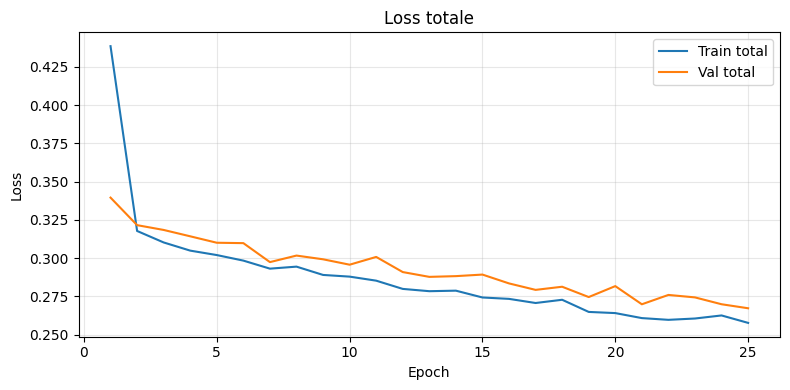

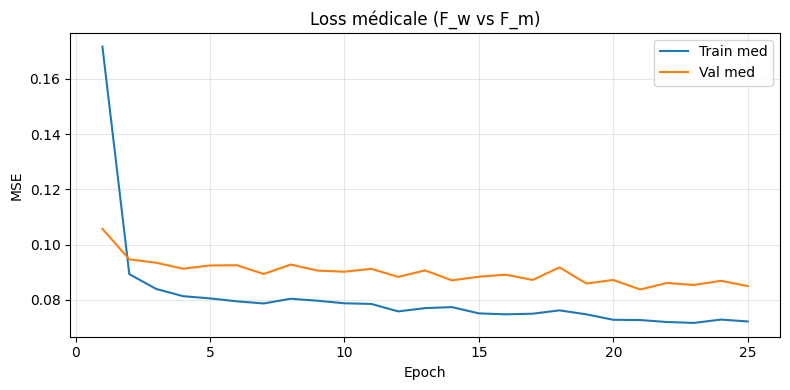

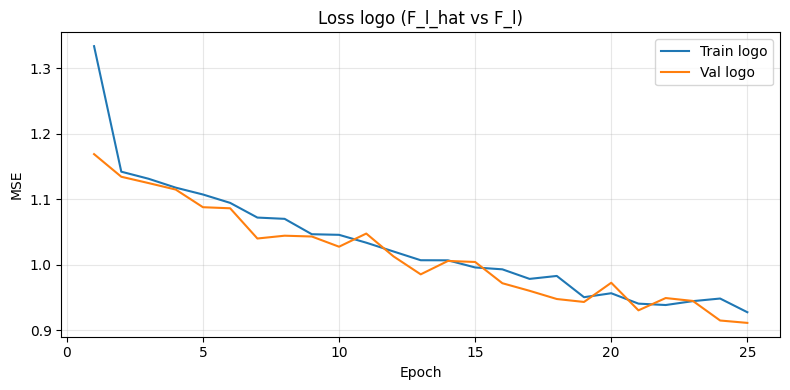

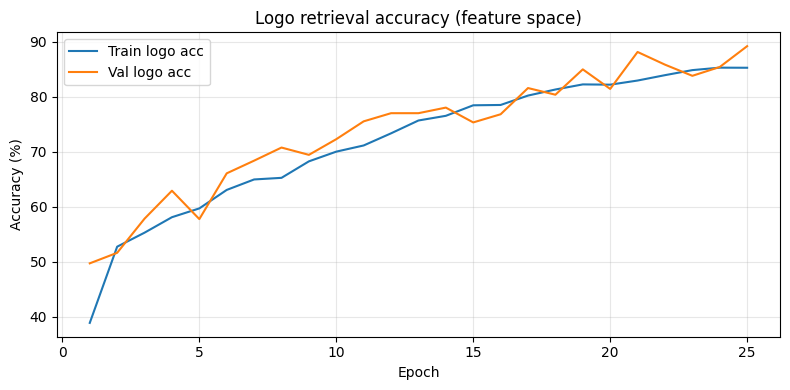

In [21]:
epochs = train_history["epoch"]

plt.figure(figsize=(8,4))
plt.plot(epochs, train_history["train_loss"], label="Train total")
plt.plot(epochs, train_history["val_loss"],   label="Val total")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss totale")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, train_history["train_med_loss"], label="Train med")
plt.plot(epochs, train_history["val_med_loss"],   label="Val med")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Loss médicale (F_w vs F_m)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, train_history["train_logo_loss"], label="Train logo")
plt.plot(epochs, train_history["val_logo_loss"],   label="Val logo")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Loss logo (F_l_hat vs F_l)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, train_history["train_logo_acc"], label="Train logo acc")
plt.plot(epochs, train_history["val_logo_acc"],   label="Val logo acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Logo retrieval accuracy (feature space)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:
def psnr(mse, max_value=1.0):
    if mse == 0:
        return float("inf")
    return 20 * np.log10(max_value) - 10 * np.log10(mse)


def vector_ssim(x, y):
    """
    Version simplifiée type-SSIM pour deux vecteurs 1D de features.
    Utilise les mêmes idées (moyennes, variances, covariance).
    """
    x = np.asarray(x, dtype=np.float32).ravel()
    y = np.asarray(y, dtype=np.float32).ravel()

    if np.allclose(x, y):
        return 1.0

    vmin = min(x.min(), y.min())
    vmax = max(x.max(), y.max())
    if vmax > vmin:
        x_n = (x - vmin) / (vmax - vmin)
        y_n = (y - vmin) / (vmax - vmin)
    else:
        return 1.0

    mu_x = x_n.mean()
    mu_y = y_n.mean()
    sigma_x2 = x_n.var()
    sigma_y2 = y_n.var()
    sigma_xy = ((x_n - mu_x) * (y_n - mu_y)).mean()

    C1 = (0.01 ** 2)
    C2 = (0.03 ** 2)

    num   = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    denom = (mu_x**2 + mu_y**2 + C1) * (sigma_x2 + sigma_y2 + C2)

    if denom == 0:
        return 1.0

    return float(num / denom)


In [23]:
encoder.eval()
decoder.eval()

all_med_mse = []
all_logo_mse = []
all_med_psnr = []
all_logo_psnr = []
all_logo_ssim = []

with torch.no_grad():
    for F_m, F_l in val_dl:
        F_m = F_m.to(device)
        F_l = F_l.to(device)

        F_w = encoder(F_m, F_l)
        F_l_hat = decoder(F_w)

        F_m_np     = F_m.cpu().numpy()
        F_l_np     = F_l.cpu().numpy()
        F_w_np     = F_w.cpu().numpy()
        F_l_hat_np = F_l_hat.cpu().numpy()

        mse_med = np.mean((F_w_np - F_m_np) ** 2)
        all_med_mse.append(mse_med)
        all_med_psnr.append(psnr(mse_med, max_value=1.0))

        mse_logo = np.mean((F_l_hat_np - F_l_np) ** 2)
        all_logo_mse.append(mse_logo)
        all_logo_psnr.append(psnr(mse_logo, max_value=1.0))

        for i in range(F_l_np.shape[0]):
            s = vector_ssim(F_l_np[i], F_l_hat_np[i])
            all_logo_ssim.append(s)

print("=== Validation (sans attaque) ===")
print(f"Medical MSE (F_w vs F_m):  {np.mean(all_med_mse):.6f}")
print(f"Medical PSNR:              {np.mean(all_med_psnr):.2f} dB")
print(f"Logo MSE (F_l_hat vs F_l): {np.mean(all_logo_mse):.6f}")
print(f"Logo PSNR:                 {np.mean(all_logo_psnr):.2f} dB")
print(f"Logo SSIM (features):      {np.mean(all_logo_ssim):.4f}")


=== Validation (sans attaque) ===
Medical MSE (F_w vs F_m):  0.085042
Medical PSNR:              10.76 dB
Logo MSE (F_l_hat vs F_l): 0.918567
Logo PSNR:                 0.38 dB
Logo SSIM (features):      0.8235


In [24]:
def attack_gaussian_noise(F_w_np, sigma=0.05):
    noise = np.random.normal(0, sigma, size=F_w_np.shape).astype(np.float32)
    return F_w_np + noise

def attack_scaling(F_w_np, alpha=0.9):
    return alpha * F_w_np


encoder.eval()
decoder.eval()

all_logo_mse_clean  = []
all_logo_mse_noise  = []
all_logo_mse_scaled = []

with torch.no_grad():
    for F_m, F_l in val_dl:
        F_m = F_m.to(device)
        F_l = F_l.to(device)

        F_w = encoder(F_m, F_l)
        F_w_np = F_w.cpu().numpy()
        F_l_np = F_l.cpu().numpy()

        # attaques
        F_w_noise_np  = attack_gaussian_noise(F_w_np, sigma=0.05)
        F_w_scaled_np = attack_scaling(F_w_np, alpha=0.9)

        F_w_noise  = torch.from_numpy(F_w_noise_np).to(device)
        F_w_scaled = torch.from_numpy(F_w_scaled_np).to(device)

        F_l_hat_clean  = decoder(F_w)
        F_l_hat_noise  = decoder(F_w_noise)
        F_l_hat_scaled = decoder(F_w_scaled)

        F_l_hat_clean_np  = F_l_hat_clean.cpu().numpy()
        F_l_hat_noise_np  = F_l_hat_noise.cpu().numpy()
        F_l_hat_scaled_np = F_l_hat_scaled.cpu().numpy()

        mse_clean  = np.mean((F_l_hat_clean_np  - F_l_np) ** 2)
        mse_noise  = np.mean((F_l_hat_noise_np  - F_l_np) ** 2)
        mse_scaled = np.mean((F_l_hat_scaled_np - F_l_np) ** 2)

        all_logo_mse_clean.append(mse_clean)
        all_logo_mse_noise.append(mse_noise)
        all_logo_mse_scaled.append(mse_scaled)

print("=== Attack simulation on watermark recovery (ViT features) ===")
print(f"Logo MSE (clean):   {np.mean(all_logo_mse_clean):.6f}")
print(f"Logo MSE (noise):   {np.mean(all_logo_mse_noise):.6f}")
print(f"Logo MSE (scaled):  {np.mean(all_logo_mse_scaled):.6f}")

print("\nPSNR (higher is better):")
print(f"Logo PSNR (clean):  {psnr(np.mean(all_logo_mse_clean)):.2f} dB")
print(f"Logo PSNR (noise):  {psnr(np.mean(all_logo_mse_noise)):.2f} dB")
print(f"Logo PSNR (scaled): {psnr(np.mean(all_logo_mse_scaled)):.2f} dB")


=== Attack simulation on watermark recovery (ViT features) ===
Logo MSE (clean):   0.912973
Logo MSE (noise):   0.918774
Logo MSE (scaled):  0.940379

PSNR (higher is better):
Logo PSNR (clean):  0.40 dB
Logo PSNR (noise):  0.37 dB
Logo PSNR (scaled): 0.27 dB


In [25]:
# === ResNet+CBAM feature extraction setup ===
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# On réutilise les mêmes racines que pour ViT
MED_ROOT  = Path(r"C:\Users\bacht\Desktop\medhalf")
LOGO_ROOT = Path(r"C:\Users\bacht\Desktop\ITFFC\logos")

RES_FEATURES_DIR = MED_ROOT / "features_resnet_cbam"
RES_FEATURES_DIR.mkdir(parents=True, exist_ok=True)

print("MED_ROOT         :", MED_ROOT)
print("LOGO_ROOT        :", LOGO_ROOT)
print("RES_FEATURES_DIR :", RES_FEATURES_DIR)

IMG_SIZE   = 224
NUM_WORKERS = 0
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Si med_df / logo_df existent déjà, on les réutilise. Sinon on les reconstruit.
def ensure_med_logo_dfs():
    global med_df, logo_df
    if "med_df" in globals() and "logo_df" in globals():
        return
    print("[info] Reconstruction de med_df / logo_df...")
    # MED
    def scan_medhalf(root: Path) -> pd.DataFrame:
        rows = []
        exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
        for class_dir in sorted(root.iterdir()):
            if not class_dir.is_dir():
                continue
            cls = class_dir.name
            for p in class_dir.rglob("*"):
                if p.is_file() and p.suffix.lower() in exts:
                    rows.append({"split": "All", "class": cls, "path": str(p)})
        return pd.DataFrame(rows)
    # LOGO
    def scan_logos(root: Path) -> pd.DataFrame:
        rows = []
        exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
        for split in ["Train", "Test"]:
            split_dir = root / split
            if not split_dir.exists():
                continue
            for p in split_dir.rglob("*"):
                if p.is_file() and p.suffix.lower() in exts:
                    rows.append({"split": f"Logo{split}", "class": "logo", "path": str(p)})
        return pd.DataFrame(rows)
    med_df = scan_medhalf(MED_ROOT)
    logo_df = scan_logos(LOGO_ROOT)

ensure_med_logo_dfs()

class MedDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_size: int = 224):
        self.df = df.reset_index(drop=True)
        self.classes = sorted(df["class"].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        x = self.tf(img)
        y = self.class_to_idx[row["class"]]
        return x, y

class LogoDatasetFlat(Dataset):
    def __init__(self, df: pd.DataFrame, img_size: int = 224):
        self.df = df.reset_index(drop=True)
        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        x = self.tf(img)
        y = 0
        return x, y

med_res_ds  = MedDataset(med_df, img_size=IMG_SIZE)
logo_res_ds = LogoDatasetFlat(logo_df, img_size=IMG_SIZE)

med_res_dl  = DataLoader(med_res_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)
logo_res_dl = DataLoader(logo_res_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True)

print("MED (ResNet) size :", len(med_res_ds),  "| classes:", med_res_ds.classes)
print("LOGO (ResNet) size:", len(logo_res_ds), "| classes: ['logo']")


MED_ROOT         : C:\Users\bacht\Desktop\medhalf
LOGO_ROOT        : C:\Users\bacht\Desktop\ITFFC\logos
RES_FEATURES_DIR : C:\Users\bacht\Desktop\medhalf\features_resnet_cbam
MED (ResNet) size : 12800 | classes: ['ModerateDemented_processed', 'NonDemented_processed', 'notumor_processed', 'pituitary_processed']
LOGO (ResNet) size: 4480 | classes: ['logo']


In [27]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

# === CBAM modules ===
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        assert kernel_size in (3,7)
        padding = 3 if kernel_size == 7 else 1
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out,_ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv(x_cat)
        return self.sigmoid(x_out)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)
    def forward(self, x):
        out = self.ca(x) * x
        out = self.sa(out) * out
        return out

# === ResNet50 + CBAM feature extractor ===
class ResNet50_CBAM_FeatureExtractor(nn.Module):
    """
    Utilise ResNet50 pré-entraîné, applique CBAM sur le dernier feature map
    (layer4), puis global average pooling -> vecteur 2048-d.
    """
    def __init__(self):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # garder tout sauf la FC
        self.stem = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool,
        )
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        self.cbam   = CBAM(in_planes=2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)         # [B,2048,H,W]
        x = self.cbam(x)
        x = self.avgpool(x)        # [B,2048,1,1]
        x = torch.flatten(x, 1)    # [B,2048]
        return x

def build_resnet_cbam_extractor():
    m = ResNet50_CBAM_FeatureExtractor()
    m.eval().to(device)
    feat_dim = 2048
    return m, feat_dim

@torch.no_grad()
def extract_features_resnet(backbone: nn.Module, loader: DataLoader, feat_dim: int) -> np.ndarray:
    feats = np.zeros((len(loader.dataset), feat_dim), dtype=np.float32)
    ptr = 0
    for xb, yb in loader:
        xb = xb.to(device)
        out = backbone(xb)
        out = out.detach().cpu().numpy()
        n = out.shape[0]
        feats[ptr:ptr+n] = out
        ptr += n
    return feats

def save_resnet_features(prefix: str, df: pd.DataFrame, feats: np.ndarray, model_tag: str):
    npy_path = RES_FEATURES_DIR / f"{prefix}_{model_tag}_features.npy"
    np.save(npy_path, feats)
    meta = pd.DataFrame({
        "path": df["path"].values,
        "class": df["class"].values,
        "split": df["split"].values,
    })
    csv_path = RES_FEATURES_DIR / f"{prefix}_{model_tag}_meta.csv"
    meta.to_csv(csv_path, index=False)
    print(f"Saved: {npy_path.name}, {csv_path.name}")


In [28]:
resnet_cbam, res_feat_dim = build_resnet_cbam_extractor()
print("ResNet+CBAM feature dim:", res_feat_dim)

print("[MED] Extraction ResNet+CBAM...")
med_res_feats = extract_features_resnet(resnet_cbam, med_res_dl, res_feat_dim)
save_resnet_features("med", med_df, med_res_feats, "resnet_cbam")

print("[LOGO] Extraction ResNet+CBAM...")
logo_res_feats = extract_features_resnet(resnet_cbam, logo_res_dl, res_feat_dim)
save_resnet_features("logo", logo_df, logo_res_feats, "resnet_cbam")

print("\n✅ ResNet+CBAM features saved in:", RES_FEATURES_DIR)
for p in sorted(RES_FEATURES_DIR.glob("*.npy")):
    print(" -", p.name)
for p in sorted(RES_FEATURES_DIR.glob("*.csv")):
    print(" -", p.name)


ResNet+CBAM feature dim: 2048
[MED] Extraction ResNet+CBAM...
Saved: med_resnet_cbam_features.npy, med_resnet_cbam_meta.csv
[LOGO] Extraction ResNet+CBAM...
Saved: logo_resnet_cbam_features.npy, logo_resnet_cbam_meta.csv

✅ ResNet+CBAM features saved in: C:\Users\bacht\Desktop\medhalf\features_resnet_cbam
 - logo_resnet_cbam_features.npy
 - med_resnet_cbam_features.npy
 - logo_resnet_cbam_meta.csv
 - med_resnet_cbam_meta.csv


In [29]:
# === Embedding with ResNet+CBAM features ===
med_res_feat_path  = RES_FEATURES_DIR / "med_resnet_cbam_features.npy"
med_res_meta_path  = RES_FEATURES_DIR / "med_resnet_cbam_meta.csv"
logo_res_feat_path = RES_FEATURES_DIR / "logo_resnet_cbam_features.npy"
logo_res_meta_path = RES_FEATURES_DIR / "logo_resnet_cbam_meta.csv"

med_res_feats  = np.load(med_res_feat_path).astype(np.float32)
logo_res_feats = np.load(logo_res_feat_path).astype(np.float32)

med_res_meta  = pd.read_csv(med_res_meta_path)
logo_res_meta = pd.read_csv(logo_res_meta_path)

print("med_res_feats shape :", med_res_feats.shape)
print("logo_res_feats shape:", logo_res_feats.shape)

res_feat_dim = med_res_feats.shape[1]
print("ResNet+CBAM feature dimension:", res_feat_dim)


med_res_feats shape : (12800, 2048)
logo_res_feats shape: (4480, 2048)
ResNet+CBAM feature dimension: 2048


In [30]:
from torch.utils.data import random_split, Dataset, DataLoader

class ResEmbeddingDataset(Dataset):
    """
    Dataset embedding basé sur features ResNet+CBAM:
      - F_m : medical features
      - F_l : logo features (échantillonnés aléatoirement)
    """
    def __init__(self, med_feats: np.ndarray, logo_feats: np.ndarray):
        self.med_feats  = med_feats.astype(np.float32)
        self.logo_feats = logo_feats.astype(np.float32)
        self.num_med  = self.med_feats.shape[0]
        self.num_logo = self.logo_feats.shape[0]
    def __len__(self):
        return self.num_med
    def __getitem__(self, idx):
        F_m = self.med_feats[idx]
        l_idx = np.random.randint(0, self.num_logo)
        F_l = self.logo_feats[l_idx]
        return torch.from_numpy(F_m), torch.from_numpy(F_l)

res_full_dataset = ResEmbeddingDataset(med_res_feats, logo_res_feats)

val_ratio = 0.2
n_total = len(res_full_dataset)
n_val   = int(n_total * val_ratio)
n_train = n_total - n_val

res_train_ds, res_val_ds = random_split(
    res_full_dataset,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

BATCH_SIZE_RES = 64

res_train_dl = DataLoader(res_train_ds, batch_size=BATCH_SIZE_RES, shuffle=True)
res_val_dl   = DataLoader(res_val_ds,   batch_size=BATCH_SIZE_RES, shuffle=False)

print(f"[ResNet] Train size: {len(res_train_ds)} | Val size: {len(res_val_ds)}")


[ResNet] Train size: 10240 | Val size: 2560


In [31]:
class ResEncoder(nn.Module):
    def __init__(self, feat_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 * feat_dim, 4 * feat_dim),
            nn.ReLU(),
            nn.Linear(4 * feat_dim, 2 * feat_dim),
            nn.ReLU(),
            nn.Linear(2 * feat_dim, feat_dim)
        )
    def forward(self, F_m, F_l):
        x = torch.cat([F_m, F_l], dim=1)
        return self.net(x)

class ResDecoder(nn.Module):
    def __init__(self, feat_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 2 * feat_dim),
            nn.ReLU(),
            nn.Linear(2 * feat_dim, feat_dim)
        )
    def forward(self, F_w):
        return self.net(F_w)

res_encoder = ResEncoder(res_feat_dim).to(device)
res_decoder = ResDecoder(res_feat_dim).to(device)

print(res_encoder)
print(res_decoder)


ResEncoder(
  (net): Sequential(
    (0): Linear(in_features=4096, out_features=8192, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8192, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=2048, bias=True)
  )
)
ResDecoder(
  (net): Sequential(
    (0): Linear(in_features=2048, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
  )
)


In [32]:
lambda_med_res  = 1.0
lambda_logo_res = 0.2

res_criterion = nn.MSELoss()
res_params = list(res_encoder.parameters()) + list(res_decoder.parameters())
res_optimizer = torch.optim.Adam(res_params, lr=1e-3)

EPOCHS_RES = 25  # même ordre de grandeur

def batch_logo_retrieval_accuracy(F_l_hat: torch.Tensor, F_l: torch.Tensor):
    F_l_hat_n = F_l_hat / (F_l_hat.norm(dim=1, keepdim=True) + 1e-8)
    F_l_n     = F_l     / (F_l.norm(dim=1,     keepdim=True) + 1e-8)
    sim = F_l_hat_n @ F_l_n.T
    pred_idx   = sim.argmax(dim=1)
    target_idx = torch.arange(F_l.size(0), device=F_l.device)
    correct = (pred_idx == target_idx).sum().item()
    total   = F_l.size(0)
    return correct, total

def res_train_one_epoch():
    res_encoder.train()
    res_decoder.train()
    total_loss = total_med = total_logo = 0.0
    n_samples = 0
    total_logo_correct = 0
    total_logo_samples = 0
    for F_m, F_l in res_train_dl:
        F_m = F_m.to(device)
        F_l = F_l.to(device)
        F_w = res_encoder(F_m, F_l)
        F_l_hat = res_decoder(F_w)
        loss_med  = res_criterion(F_w, F_m)
        loss_logo = res_criterion(F_l_hat, F_l)
        loss = lambda_med_res * loss_med + lambda_logo_res * loss_logo
        res_optimizer.zero_grad()
        loss.backward()
        res_optimizer.step()
        bs = F_m.size(0)
        total_loss += loss.item() * bs
        total_med  += loss_med.item() * bs
        total_logo += loss_logo.item() * bs
        n_samples  += bs
        c,t = batch_logo_retrieval_accuracy(F_l_hat, F_l)
        total_logo_correct += c
        total_logo_samples += t
    return (total_loss/n_samples,
            total_med/n_samples,
            total_logo/n_samples,
            100.0*total_logo_correct/total_logo_samples)

def res_eval_one_epoch():
    res_encoder.eval()
    res_decoder.eval()
    total_loss = total_med = total_logo = 0.0
    n_samples = 0
    total_logo_correct = 0
    total_logo_samples = 0
    with torch.no_grad():
        for F_m, F_l in res_val_dl:
            F_m = F_m.to(device)
            F_l = F_l.to(device)
            F_w = res_encoder(F_m, F_l)
            F_l_hat = res_decoder(F_w)
            loss_med  = res_criterion(F_w, F_m)
            loss_logo = res_criterion(F_l_hat, F_l)
            loss = lambda_med_res * loss_med + lambda_logo_res * loss_logo
            bs = F_m.size(0)
            total_loss += loss.item() * bs
            total_med  += loss_med.item() * bs
            total_logo += loss_logo.item() * bs
            n_samples  += bs
            c,t = batch_logo_retrieval_accuracy(F_l_hat, F_l)
            total_logo_correct += c
            total_logo_samples += t
    return (total_loss/n_samples,
            total_med/n_samples,
            total_logo/n_samples,
            100.0*total_logo_correct/total_logo_samples)

res_history = {
    "epoch": [],
    "train_loss": [], "val_loss": [],
    "train_med": [], "val_med": [],
    "train_logo": [], "val_logo": [],
    "train_acc": [], "val_acc": [],
}

for epoch in range(1, EPOCHS_RES+1):
    tr_loss, tr_med, tr_logo, tr_acc = res_train_one_epoch()
    val_loss, val_med, val_logo, val_acc = res_eval_one_epoch()
    res_history["epoch"].append(epoch)
    res_history["train_loss"].append(tr_loss)
    res_history["val_loss"].append(val_loss)
    res_history["train_med"].append(tr_med)
    res_history["val_med"].append(val_med)
    res_history["train_logo"].append(tr_logo)
    res_history["val_logo"].append(val_logo)
    res_history["train_acc"].append(tr_acc)
    res_history["val_acc"].append(val_acc)
    print(
        f"[ResNet] Epoch {epoch:02d} | "
        f"Train: loss={tr_loss:.4f} (med={tr_med:.4f}, logo={tr_logo:.4f}, acc={tr_acc:.2f}%) | "
        f"Val:   loss={val_loss:.4f} (med={val_med:.4f}, logo={val_logo:.4f}, acc={val_acc:.2f}%)"
    )


[ResNet] Epoch 01 | Train: loss=0.0001 (med=0.0001, logo=0.0002, acc=1.60%) | Val:   loss=0.0001 (med=0.0000, logo=0.0002, acc=1.76%)
[ResNet] Epoch 02 | Train: loss=0.0001 (med=0.0000, logo=0.0002, acc=3.30%) | Val:   loss=0.0001 (med=0.0000, logo=0.0002, acc=5.31%)
[ResNet] Epoch 03 | Train: loss=0.0001 (med=0.0000, logo=0.0002, acc=5.63%) | Val:   loss=0.0001 (med=0.0000, logo=0.0002, acc=7.73%)
[ResNet] Epoch 04 | Train: loss=0.0001 (med=0.0000, logo=0.0002, acc=9.14%) | Val:   loss=0.0001 (med=0.0000, logo=0.0002, acc=12.73%)
[ResNet] Epoch 05 | Train: loss=0.0001 (med=0.0000, logo=0.0002, acc=12.38%) | Val:   loss=0.0001 (med=0.0000, logo=0.0002, acc=15.27%)
[ResNet] Epoch 06 | Train: loss=0.0001 (med=0.0000, logo=0.0002, acc=15.20%) | Val:   loss=0.0001 (med=0.0000, logo=0.0002, acc=18.20%)
[ResNet] Epoch 07 | Train: loss=0.0001 (med=0.0000, logo=0.0002, acc=18.48%) | Val:   loss=0.0001 (med=0.0000, logo=0.0002, acc=21.41%)
[ResNet] Epoch 08 | Train: loss=0.0000 (med=0.0000, log

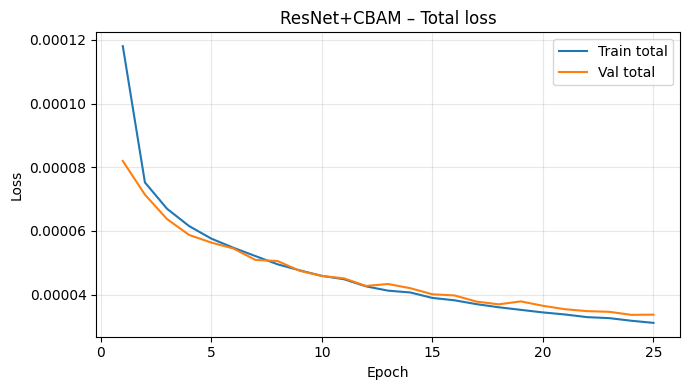

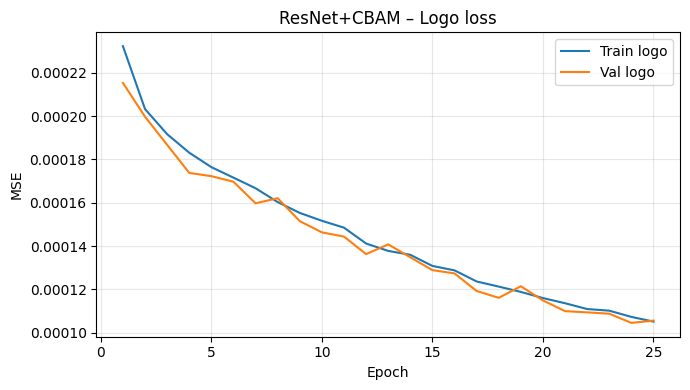

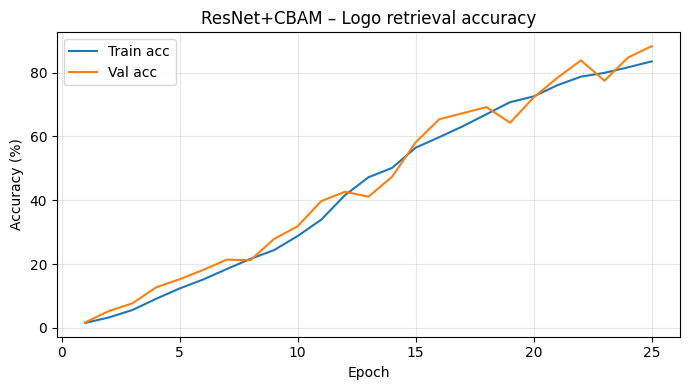

In [33]:
epochs = res_history["epoch"]

plt.figure(figsize=(7,4))
plt.plot(epochs, res_history["train_loss"], label="Train total")
plt.plot(epochs, res_history["val_loss"],   label="Val total")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("ResNet+CBAM – Total loss")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, res_history["train_logo"], label="Train logo")
plt.plot(epochs, res_history["val_logo"],   label="Val logo")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("ResNet+CBAM – Logo loss")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, res_history["train_acc"], label="Train acc")
plt.plot(epochs, res_history["val_acc"],   label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("ResNet+CBAM – Logo retrieval accuracy")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [34]:
def psnr(mse, max_value=1.0):
    if mse == 0:
        return float("inf")
    return 20 * np.log10(max_value) - 10 * np.log10(mse)

def vector_ssim(x, y):
    x = np.asarray(x, dtype=np.float32).ravel()
    y = np.asarray(y, dtype=np.float32).ravel()
    if np.allclose(x, y):
        return 1.0
    vmin = min(x.min(), y.min())
    vmax = max(x.max(), y.max())
    if vmax > vmin:
        x_n = (x - vmin) / (vmax - vmin)
        y_n = (y - vmin) / (vmax - vmin)
    else:
        return 1.0
    mu_x = x_n.mean(); mu_y = y_n.mean()
    sigma_x2 = x_n.var(); sigma_y2 = y_n.var()
    sigma_xy = ((x_n - mu_x) * (y_n - mu_y)).mean()
    C1 = (0.01 ** 2); C2 = (0.03 ** 2)
    num   = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    denom = (mu_x**2 + mu_y**2 + C1) * (sigma_x2 + sigma_y2 + C2)
    if denom == 0:
        return 1.0
    return float(num / denom)


In [35]:
res_encoder.eval()
res_decoder.eval()

all_med_mse_res = []
all_logo_mse_res = []
all_med_psnr_res = []
all_logo_psnr_res = []
all_logo_ssim_res = []

with torch.no_grad():
    for F_m, F_l in res_val_dl:
        F_m = F_m.to(device)
        F_l = F_l.to(device)

        F_w = res_encoder(F_m, F_l)
        F_l_hat = res_decoder(F_w)

        F_m_np     = F_m.cpu().numpy()
        F_l_np     = F_l.cpu().numpy()
        F_w_np     = F_w.cpu().numpy()
        F_l_hat_np = F_l_hat.cpu().numpy()

        mse_med = np.mean((F_w_np - F_m_np) ** 2)
        all_med_mse_res.append(mse_med)
        all_med_psnr_res.append(psnr(mse_med, max_value=1.0))

        mse_logo = np.mean((F_l_hat_np - F_l_np) ** 2)
        all_logo_mse_res.append(mse_logo)
        all_logo_psnr_res.append(psnr(mse_logo, max_value=1.0))

        for i in range(F_l_np.shape[0]):
            s = vector_ssim(F_l_np[i], F_l_hat_np[i])
            all_logo_ssim_res.append(s)

print("=== ResNet+CBAM – Validation (sans attaque) ===")
print(f"Medical MSE (F_w vs F_m):  {np.mean(all_med_mse_res):.6f}")
print(f"Medical PSNR:              {np.mean(all_med_psnr_res):.2f} dB")
print(f"Logo MSE (F_l_hat vs F_l): {np.mean(all_logo_mse_res):.6f}")
print(f"Logo PSNR:                 {np.mean(all_logo_psnr_res):.2f} dB")
print(f"Logo SSIM (features):      {np.mean(all_logo_ssim_res):.4f}")


=== ResNet+CBAM – Validation (sans attaque) ===
Medical MSE (F_w vs F_m):  0.000012
Medical PSNR:              49.09 dB
Logo MSE (F_l_hat vs F_l): 0.000104
Logo PSNR:                 39.83 dB
Logo SSIM (features):      0.8195


In [36]:
def attack_gaussian_noise(F_w_np, sigma=0.05):
    noise = np.random.normal(0, sigma, size=F_w_np.shape).astype(np.float32)
    return F_w_np + noise

def attack_scaling(F_w_np, alpha=0.9):
    return alpha * F_w_np

res_encoder.eval()
res_decoder.eval()

all_logo_mse_clean_res  = []
all_logo_mse_noise_res  = []
all_logo_mse_scaled_res = []

with torch.no_grad():
    for F_m, F_l in res_val_dl:
        F_m = F_m.to(device)
        F_l = F_l.to(device)

        F_w = res_encoder(F_m, F_l)
        F_w_np = F_w.cpu().numpy()
        F_l_np = F_l.cpu().numpy()

        F_w_noise_np  = attack_gaussian_noise(F_w_np, sigma=0.05)
        F_w_scaled_np = attack_scaling(F_w_np, alpha=0.9)

        F_w_noise  = torch.from_numpy(F_w_noise_np).to(device)
        F_w_scaled = torch.from_numpy(F_w_scaled_np).to(device)

        F_l_hat_clean  = res_decoder(F_w)
        F_l_hat_noise  = res_decoder(F_w_noise)
        F_l_hat_scaled = res_decoder(F_w_scaled)

        F_l_hat_clean_np  = F_l_hat_clean.cpu().numpy()
        F_l_hat_noise_np  = F_l_hat_noise.cpu().numpy()
        F_l_hat_scaled_np = F_l_hat_scaled.cpu().numpy()

        mse_clean  = np.mean((F_l_hat_clean_np  - F_l_np) ** 2)
        mse_noise  = np.mean((F_l_hat_noise_np  - F_l_np) ** 2)
        mse_scaled = np.mean((F_l_hat_scaled_np - F_l_np) ** 2)

        all_logo_mse_clean_res.append(mse_clean)
        all_logo_mse_noise_res.append(mse_noise)
        all_logo_mse_scaled_res.append(mse_scaled)

print("=== ResNet+CBAM – Attack simulation on watermark recovery ===")
print(f"Logo MSE (clean):   {np.mean(all_logo_mse_clean_res):.6f}")
print(f"Logo MSE (noise):   {np.mean(all_logo_mse_noise_res):.6f}")
print(f"Logo MSE (scaled):  {np.mean(all_logo_mse_scaled_res):.6f}")

print("\nPSNR (higher is better):")
print(f"Logo PSNR (clean):  {psnr(np.mean(all_logo_mse_clean_res)):.2f} dB")
print(f"Logo PSNR (noise):  {psnr(np.mean(all_logo_mse_noise_res)):.2f} dB")
print(f"Logo PSNR (scaled): {psnr(np.mean(all_logo_mse_scaled_res)):.2f} dB")


=== ResNet+CBAM – Attack simulation on watermark recovery ===
Logo MSE (clean):   0.000102
Logo MSE (noise):   0.001662
Logo MSE (scaled):  0.000104

PSNR (higher is better):
Logo PSNR (clean):  39.92 dB
Logo PSNR (noise):  27.79 dB
Logo PSNR (scaled): 39.83 dB
